# **CNN Encoder Decoder SE Block with COCO using pretrained ResNet18**

In the current computational notebook, we have implemented a convolutional autoencoder. The encoder part of the autoencoder utilizes the pretrained ResNet18 model, which enables us to fine-tune the model and expedite training by leveraging the features learned during training with the ImageNet dataset. For the decoder part, we have designed a deconvolution architecture consisting of four layers. This decoder architecture receives information from the pretrained ResNet18 model and incorporates a Squeeze-and-Excitation (SE) block. However, the decoder part is trained from scratch.

The incorporation of the SE block between the encoder and decoder modules serves the purpose of enhancing the model's performance in color reconstruction. This strategic integration enables the model to discern and emphasize the most relevant filters for the task at hand.

Our design adaptation is primarily motivated by the focus on color reconstruction, which is rooted in our dataset consisting of diverse facial images. Throughout the training and testing processes, we have meticulously utilized this dataset to provide a comprehensive and relevant knowledge base for the model to learn from.

For readers seeking a deeper understanding and technical insights into Squeeze-and-Excitation Networks, we refer them to the scholarly work titled "Squeeze-and-Excitation Networks" by Hu et al., which was presented at the Computer Vision and Pattern Recognition (CVPR) conference in 2018.

In this model's training process, we have utilized a subset of the COCO dataset for validation, comprising 5000 images. This reduced dataset was chosen to strike a balance between simplicity and reasonable training time.

# Import necessary libraries

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import matplotlib.pyplot as plt
import zipfile
import io
from google.colab import files
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import cv2
from skimage import color
import requests
import torchvision.transforms.functional as TF

# Connect to GPU if availble 

*Clear the CUDA memory cache. This releases all unoccupied cached memory so that those can be used by CUDA operations if necessary. This can help prevent the CUDA out-of-memory errors that can occur when the memory is filled up with cached, but unused data.*

In [2]:
torch.cuda.empty_cache()

In [3]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Utils

*Request the COCO dataset and create different folders to split the data into train and test.*

In [4]:
url = "http://images.cocodataset.org/zips/val2017.zip"  # Replace with the URL of the dataset file
save_path = "dataset.zip"  # Replace with the desired save path

response = requests.get(url)
with open(save_path, "wb") as f:
    f.write(response.content)

In [5]:
# Specify the file name of the uploaded ZIP file
zip_filename = "DeepColorization-master.zip"

# Extract the contents of the ZIP file
with zipfile.ZipFile(save_path, "r") as zip_ref:
    zip_ref.extractall("face_images")

In [6]:
# Path to the extracted dataset folder
dataset_folder_path = "/content/face_images/val2017"

# Get the list of image files in the dataset folder
image_files = [f for f in os.listdir(dataset_folder_path) if os.path.isfile(os.path.join(dataset_folder_path, f))]

In [7]:
# Create directories for training and validation sets
train_folder = "/content/dataset/train"
val_folder = "/content/dataset/val"

# Create the directories if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

In [8]:
# Shuffle the image files list
random.shuffle(image_files)

# Determine the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8
split_index = int(len(image_files) * split_ratio)

# Split the image files list into training and validation sets
train_image_files = image_files[:split_index]
val_image_files = image_files[split_index:]

In [9]:
# Iterate through the training set image files
for i, image_name in enumerate(train_image_files):
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    colored_image_path = os.path.join(train_folder, image_name)
    image.save(colored_image_path)

In [10]:
# Iterate through the validation set image files
for image_name in val_image_files:
    image_path = os.path.join(dataset_folder_path, image_name)
    image = Image.open(image_path)

    # Save the colored image in the validation folder
    colored_image_path = os.path.join(val_folder, image_name)
    image.save(colored_image_path)

# RGB Colorspace

*Define the class that will generate the grayscale and the colored image in RGB. Pretrained model just accepts 3 RGB channels.*

In [11]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        
    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_files)
        
    def __getitem__(self, idx):
        # Get the image name and its corresponding path
        image_name = self.image_files[idx]
        image_path = os.path.join(self.root_dir, image_name)
        
        # Open the image
        image = Image.open(image_path)
        
        # Convert the image to grayscale
        lab_image = np.array(image)
        
        if lab_image.shape[-1] == 3:
            # If the image has 3 channels (RGB), convert it to LAB format
            lab_image = image
            image_gray = image.convert("L")
            auxiliar = torch.zeros((128,128))
            
            # Apply transform to grayscale image
            image_gray = self.transform(image_gray)
            image_gray = image_gray.squeeze(0)
            
            inp_gray = torch.stack((image_gray, auxiliar, auxiliar), axis=0)
            
            # Apply transform to the original image (LAB format)
            lab_image = self.transform(lab_image)
            
            return inp_gray, lab_image  # Return grayscale image as input and colored image as target
        else:
            # If the image doesn't have 3 channels, create an empty LAB image
            lab_image = np.zeros((2, 128, 128))
            image_gray = image.convert("L")
            auxiliar = torch.zeros((128, 128))
            
            # Apply transform to grayscale image
            image_gray = self.transform(image_gray)
            image_gray = image_gray.squeeze(0)
            
            inp_gray = torch.stack((image_gray, auxiliar, auxiliar), axis=0)
            
            return inp_gray, inp_gray  # Return grayscale image as input and target

In [12]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
   
    
])
# Define the path to your dataset directory
dataset_root = "dataset/"

# Create an instance of the custom dataset
train_dataset = ColorizationDataset(os.path.join(dataset_root, "train"), transform=transform)

#Instance of the custom validation dataset
test_dataset = ColorizationDataset(os.path.join(dataset_root, "val"), transform=transform)

# Define the batch size for the DataLoader
batch_size = 256

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the DataLoader for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Model

*Tried to freeze the parameters of the pretrained model and use the respresentation of this model to direcly reconstruct the color.*

In [13]:
def freeze_model(model):
    """
    Freezes the parameters of a model, making them untrainable during optimization.
    
    Args:
        model: The model to freeze.
    """
    for param in model.parameters():
        # Set requires_grad to False for each parameter
        param.requires_grad = False

In [14]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
      
        # Encoder layers
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)  # b, 16, 64, 64
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # b, 32, 32, 32
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # b, 64, 16, 16

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers for attention mechanism
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 512)

        # Decoder layers
        self.deconv0 = nn.ConvTranspose2d(512, 256, 4, stride=4, padding=0, output_padding=0)
        self.deconv1 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)  # b, 32, 32, 32
        self.deconv2 = nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1)  # b, 16, 64, 64
        self.deconv3 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)  # b, 2, 128, 128

    def encoder(self, x):
        # Load pretrained ResNet18 model
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:len(list(resnet.children())) - 2]
        model = torch.nn.Sequential(*modules)
        
        # Load the pretrained ResNet18 model's weights
        model.load_state_dict(resnet.state_dict(), strict=False)
        
        # Freeze the weights of the ResNet18 model
        freeze_model(model)
        
        model.to(device)
        x = model(x)
        
        return x

    def attention(self, x):
        batch_size, channels, height, width = x.size()

        # Squeeze (global average pooling)
        squeeze = self.pooling(x).view(batch_size, channels)
        
        # Excitation (fully connected layers)
        excitation = torch.nn.functional.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation))
        
        # Re-calibration
        excitation = excitation.view(batch_size, channels, 1, 1)
        scaled_feature = x * excitation.expand_as(x)

        return scaled_feature

    def decoder(self, x):
        x = self.deconv0(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv1(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv2(x)
        x = torch.nn.functional.relu(x)
        x = self.deconv3(x)
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        att = self.attention(encoded)
        decoded = self.decoder(att)
        return decoded

In [15]:
model = ConvAE().to(device)  # Create an instance of the ConvAE model and move it to the specified device

learning_rate = 0.001  # Set the learning rate for the optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Create an Adam optimizer and pass the model parameters to optimize

criterion = nn.MSELoss()  # Define the loss function (Mean Squared Error) to compare the output and target

# Training and Validation

In [16]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, feat in loader:
        # load it to the active device
        batch_features = batch_features.to(device)
        feat = feat.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, feat)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))
    return loss

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()
    
    for batch_features, feat in loader:
        batch_features = batch_features.to(device)
        feat = feat.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs,feat)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
   
    return loss

*Run the training and test.*

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils

epoch : 1/20, Train loss = 0.222289
epoch : 1/20, Test loss = 0.144279
epoch : 2/20, Train loss = 0.117860
epoch : 2/20, Test loss = 0.095148
epoch : 3/20, Train loss = 0.086885
epoch : 3/20, Test loss = 0.076409
epoch : 4/20, Train loss = 0.074118
epoch : 4/20, Test loss = 0.070060
epoch : 5/20, Train loss = 0.069529
epoch : 5/20, Test loss = 0.066350
epoch : 6/20, Train loss = 0.066542
epoch : 6/20, Test loss = 0.065473
epoch : 7/20, Train loss = 0.064893
epoch : 7/20, Test loss = 0.068217
epoch : 8/20, Train loss = 0.063842
epoch : 8/20, Test loss = 0.062225
epoch : 9/20, Train loss = 0.061997
epoch : 9/20, Test loss = 0.061375
epoch : 10/20, Train loss = 0.060877
epoch : 10/20, Test loss = 0.060640
epoch : 11/20, Train loss = 0.059356
epoch : 11/20, Test loss = 0.060299
epoch : 12/20, Train loss = 0.058154
epoch : 12/20, Test loss = 0.059699
epoch : 13/20, Train loss = 0.057816
epoch : 13/20, Test loss = 0.059214
epoch : 14/20, Train loss = 0.056624
epoch : 14/20, Test loss = 0.059

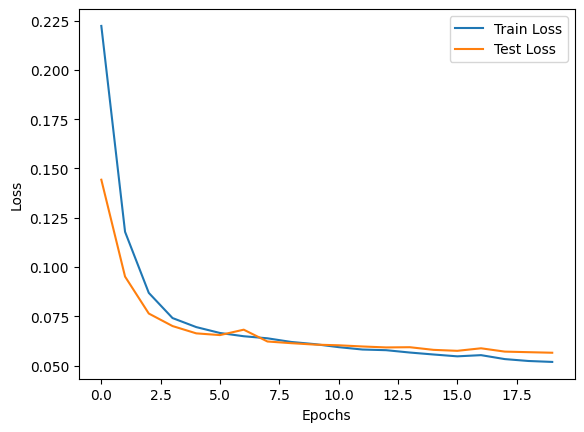

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if CUDA is available, and set the device accordingly

epochs = 20  # Set the number of epochs for training
train_loss_list = []  # Initialize an empty list to store the training loss values
test_loss_list = []  # Initialize an empty list to store the test loss values

# Loop over the specified number of epochs
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, reshape=False)  # Perform training for the current epoch and calculate the training loss
    test_loss = test(model, test_loader, criterion, reshape=False)  # Perform testing for the current epoch and calculate the test loss

    train_loss_list.append(train_loss)  # Append the training loss value to the list
    test_loss_list.append(test_loss)  # Append the test loss value to the list

# Plotting the loss curve
plt.plot(train_loss_list, label='Train Loss')  # Plot the training loss curve
plt.plot(test_loss_list, label='Test Loss')  # Plot the test loss curve
plt.xlabel('Epochs')  # Set the label for the x-axis
plt.ylabel('Loss')  # Set the label for the y-axis
plt.legend()  # Display the legend
plt.show()  # Show the plot

# Results with test

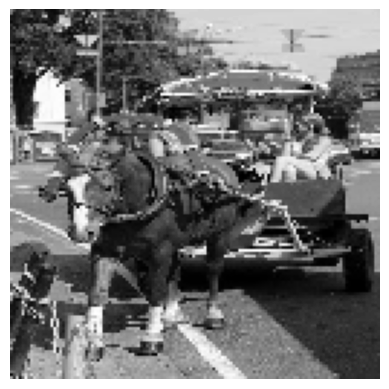

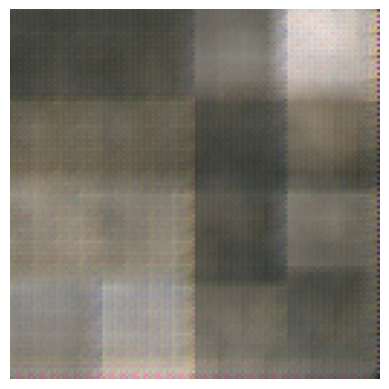

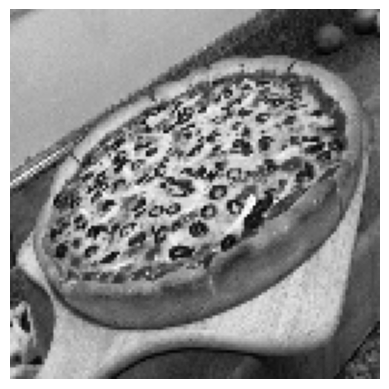

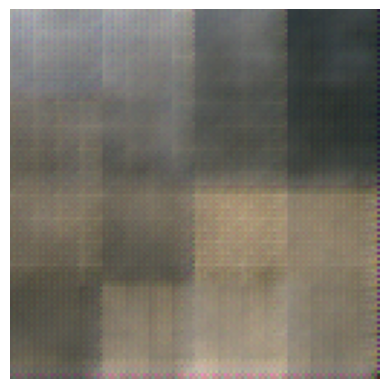

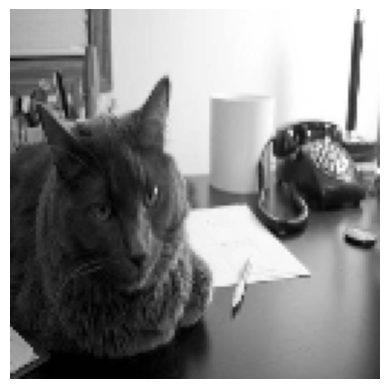

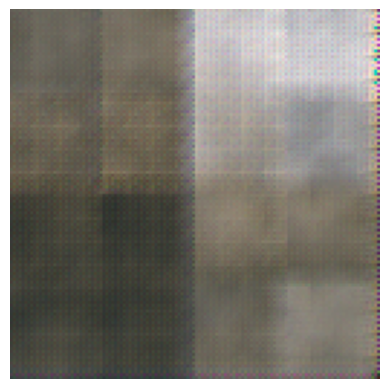

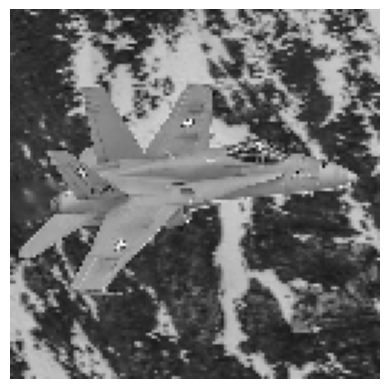

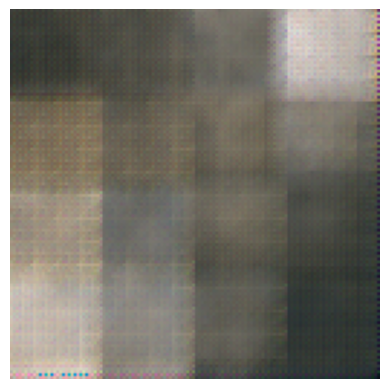

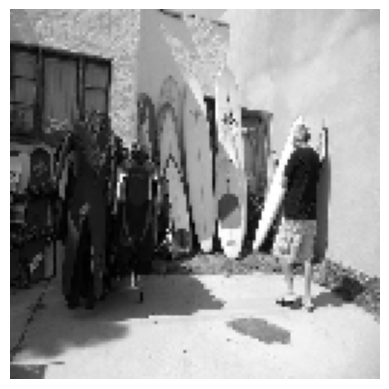

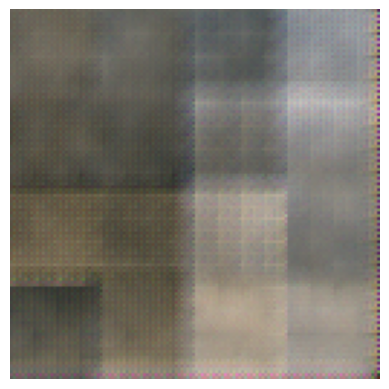

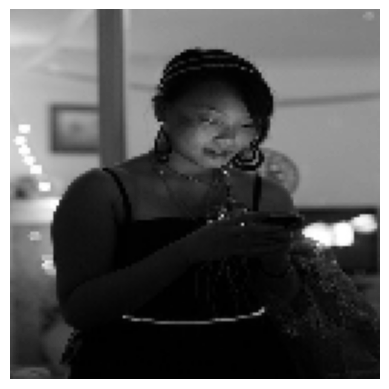

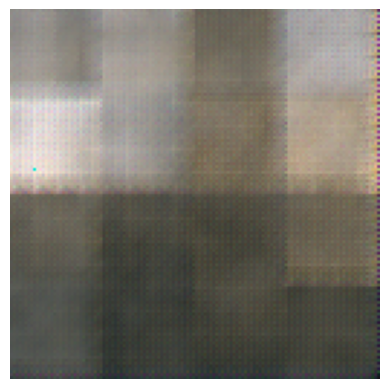

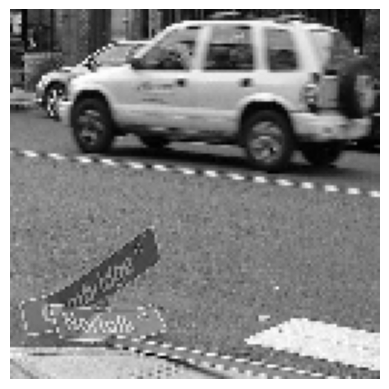

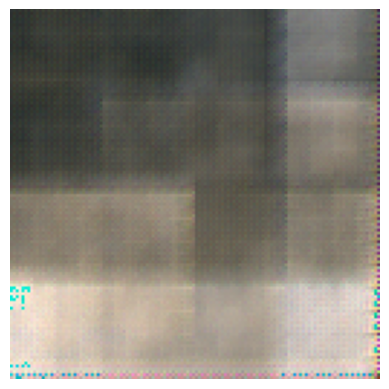

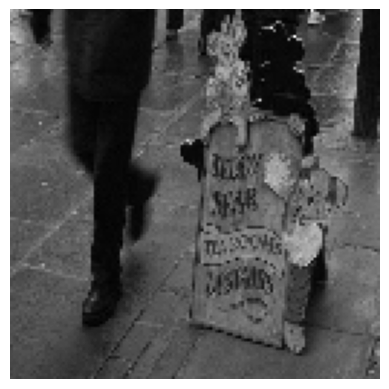

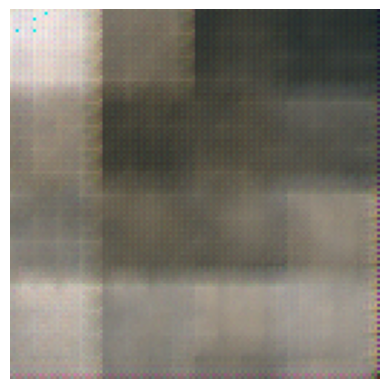

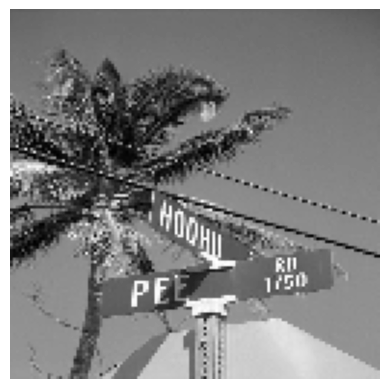

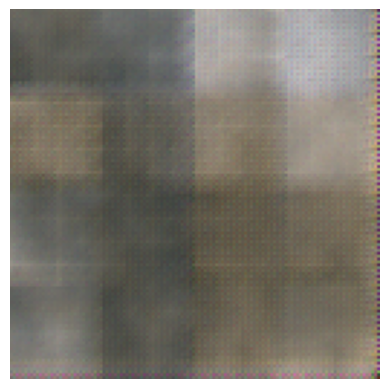

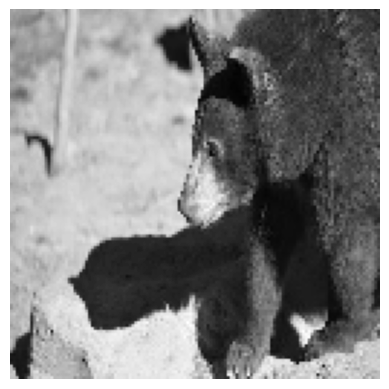

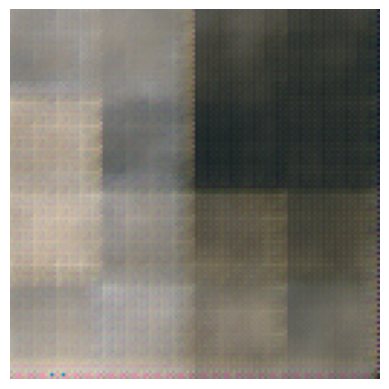

In [21]:
# Set the model to evaluation mode
model.eval()

# Plot the original grayscale images and their reconstructed colored images
test_images = 10

for i, image_name in enumerate(test_dataset):
    if i < test_images:
        # Get the grayscale image and the complete input tensor
        gray_image = image_name[0][0]
        gray_image_complete = image_name[0]
        
        # Display the original grayscale image
        plt.imshow(gray_image, cmap="gray")
        plt.axis('off')
        plt.show()

        # Preprocess the grayscale image and pass it through the model
        with torch.no_grad():
            colored_image = model(gray_image_complete.unsqueeze(0).to(device))

        # Convert the output tensor to an RGB image
        colored_image = colored_image.view(3, 128, 128)
        colored_image = colored_image.squeeze(0).cpu()
        colored_image = TF.to_pil_image(colored_image)

        # Display the reconstructed colored image
        plt.imshow(colored_image)
        plt.axis('off')
        plt.show()